# Imports

In [1]:
from data_classes import LAQNData, HealthData, MetData
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statsmodels.api import tsa

# Load data

### Load the hourly NO$_2$ data

In [2]:
species = "NO2"
url = "http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName=London/Json"
start_date = "2000-01-01"
end_date = "2021-01-01"

In [13]:
NO2 = LAQNData(url, species, start_date, end_date)

In [ ]:
#hourly_NO2_df = NO2_hourly.read_csv(index_col="date")
# hourly_NO2_df = NO2_hourly.read(sites=NO2_hourly.site_codes)
# print(hourly_NO2_df.shape)

### Load the hourly meteorology data

In [ ]:
# data_folder = path.join(path.abspath(""), "met_data")
# url = "https://bulk.meteostat.net/hourly/03772.csv.gz"

In [4]:
heathrow = MetData("Heathrow")

In [ ]:
# variables = ["temperature"]
# hourly_met_df = heathrow.read(variables)
# print(hourly_met_df.shape)

### Load the daily mortality per capita data

In [5]:
mortality = HealthData()

In [8]:
mortality_df = mortality.read("mortality-scaled")
print(mortality_df)

            deaths
1981-07-01   177.0
1981-07-02   204.0
1981-07-03   199.0
1981-07-04   197.0
1981-07-05   191.0
...            ...
2018-12-27   129.0
2018-12-28   162.0
2018-12-29   161.0
2018-12-30   145.0
2018-12-31   154.0

[13698 rows x 1 columns]


In [9]:
mortality_df["deaths_per_100k"] = mortality_df["deaths"]*100000

# Process data + plots

## Daily data

In [10]:
daily_dates = mortality_df.index

### Resample the hourly NO$_2$ data using a custom date list

Only retain the NO$_2$ data up to the final mortality datapoint:

In [ ]:
# hourly_NO2_df = hourly_NO2_df.loc[hourly_NO2_df.index < daily_dates.max()]

In [ ]:
# daily_NO2_df = hourly_NO2_df.groupby(daily_dates[daily_dates.searchsorted(hourly_NO2_df.index)]).mean()

In [24]:
daily_NO2_df = NO2.resample_time_and_log(sites=NO2.site_codes, date_index=daily_dates)

wandb: Downloading large artifact laqn-raw:latest, 1146.21MB. 192 files... Done. 0:0:0


In [25]:
daily_NO2_df.shape

(6940, 192)

### Spatially average the NO$_2$ data for all of London

In [26]:
NO2_df = NO2.regional_average_and_log(NO2.site_codes)

In [27]:
NO2_df.shape

(6940, 1)

#### Scatter plot mortality vs NO$_2$

In [ ]:
NO2_df = NO2_df.join(mortality_df)

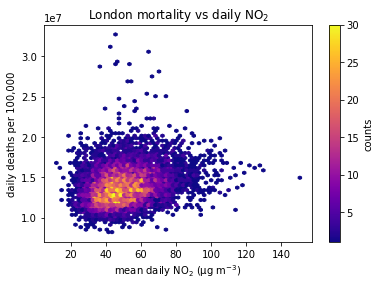

<Figure size 1440x1080 with 0 Axes>

In [22]:
plt.hexbin(NO2_df.mean_NO2, NO2_df.deaths_per_100k, cmap=cm.plasma, gridsize=70, mincnt=1)
plt.ylabel("daily deaths per 100,000")
plt.xlabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.title("London mortality vs daily NO$_2$")
plt.colorbar().set_label("counts")
plt.figure(figsize=(20,15))
plt.show()

### Resample the hourly meteorology data using a custom date list

Only retain the met data up to the final mortality datapoint:

In [ ]:
hourly_met_df = hourly_met_df.loc[hourly_met_df.index < daily_dates.max()]

In [ ]:
daily_met_df = hourly_met_df.groupby(daily_dates[daily_dates.searchsorted(hourly_met_df.index)]).mean()

In [ ]:
daily_met_df.shape

In [ ]:
daily_met_df.columns

In [ ]:
temperature_df = pd.DataFrame(daily_met_df["temperature"]).join(mortality_df)

In [ ]:
temperature_df.columns

#### Scatter plot of mortality vs temperature

In [ ]:
temperature_df.plot.scatter(x="temperature", y="deaths_per_100k", legend=False, title="London mortality").set_ylabel("daily deaths per 100,000")
plt.xlabel("mean daily temperature (℃)")
plt.show()

In [ ]:
plt.hexbin(temperature_df.temperature, temperature_df.deaths_per_100k, cmap=cm.plasma, gridsize=70, mincnt=1)
plt.ylabel("daily deaths per 100,000")
plt.xlabel("mean daily temperature (℃)")
plt.title("London mortality vs daily temperature")
plt.colorbar().set_label("counts")
plt.figure(figsize=(20,15))
plt.show()

### Scatter plot of NO$_2$ vs temperature

#### Daily averages

In [ ]:
daily_df = pd.DataFrame(NO2_df["mean_NO2"]).join(temperature_df)

In [ ]:
daily_df.columns

In [ ]:
daily_df.plot.scatter(x="temperature", y="mean_NO2", legend=False, title="London daily NO$_2$").set_ylabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.xlabel("mean daily temperature (℃)")
plt.show()

In [ ]:
plt.hexbin(daily_df.temperature, daily_df.mean_NO2, cmap=cm.plasma, gridsize=70, mincnt=1)
plt.ylabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.xlabel("mean daily temperature (℃)")
plt.title("London daily NO$_2$ vs temperature")
plt.colorbar().set_label("counts")
plt.figure(figsize=(20,15))
plt.show()

#### Hourly averages

In [ ]:
hourly_met_df.shape

In [ ]:
hourly_NO2_df.shape

In [ ]:
hourly_df = hourly_met_df.join(pd.DataFrame(hourly_NO2_df.mean(axis=1), columns=["mean_NO2"]))

In [ ]:
hourly_df.plot.scatter(x="temperature", y="mean_NO2", legend=False, title="London hourly NO$_2$").set_ylabel("hourly NO$_2$ (µg m$^{-3}$)")
plt.xlabel("hourly temperature (℃)")
plt.show()

## Time series decomposition: trends

**Trends** represent how the variable is changing overall through time.
**Seasonality** shows how the variable changes within a given period e.g. year, month.
**Residual** activity is not explained by the trend or seasonality.

Additive model: 
`y(t) = Trend(t) + Seasonality(t) + Residual(t)`

Multiplicative model:
`y(t) = Trend(t) * Seasonality(t) * Residual(t)`

#### Mortality data

Here we use the `seasonal_decompose()` function with an additive model. Note that we have to manually set `period` (for filtering) to `365`, because otherwise the function by default looks for weekly (`period=7`) trends when given daily data (inferred from the `DatetimeIndex`).

In [ ]:
decomp = tsa.seasonal_decompose(mortality_df["deaths_per_100k"], model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})

decomp_df["observed"].plot()
decomp_df["trend"].plot()
plt.legend()
plt.ylabel("deaths per 100,000")
plt.suptitle("London mortality")
plt.show()

decomp_df.loc[decomp_df.index.year>2010]["seasonal"].plot()
plt.ylabel("Seasonal variation in deaths per 100,000")
plt.suptitle("Seasonal variation: London mortality")
plt.show()

#### NO$_2$ data

In [ ]:
decomp = tsa.seasonal_decompose(daily_df["mean_NO2"], model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})

decomp_df["observed"].plot()
decomp_df["trend"].plot()
plt.legend()
plt.ylabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.suptitle("London daily NO$_2$")
plt.show()

decomp_df.loc[decomp_df.index.year>2010]["seasonal"].plot()
plt.ylabel("Seasonal variation in daily NO$_2$ (µg m$^{-3}$)")
plt.suptitle("Seasonal variation: London NO$_2$")
plt.show()

#### Temperature data

In [ ]:
decomp = tsa.seasonal_decompose(daily_df["temperature"], model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})

decomp_df["observed"].plot()
decomp_df["trend"].plot()
plt.legend()
plt.ylabel("mean daily temperature (℃)")
plt.suptitle("London daily temperature")
plt.show()

decomp_df.loc[decomp_df.index.year>2010]["seasonal"].plot()
plt.ylabel("Seasonal variation in daily temperature (℃)")
plt.suptitle("Seasonal variation: London temperature")
plt.show()